In [33]:
# Chris Yakopcic
# University of Dayton
# Feb. 1, 2019
# CNN for NSL KDD Training

##################################################################
################# User Input Section #############################
##################################################################

#######################
# Classification Type #
#######################

# Pick 1, 2, or 3
# 1: Same thing we've been doing, two outputs. normal or attack
# 2: 5 total outputs, classifing between normal and 4 different subclasses of attack
# 3: Full classification, differentiate between normal and all different attack types

class_mode = 2

###################
# Hyperparameters #
###################

# These  parameters are like global setting for your network
num_epochs = 20 #The number of times you will iterate through the dataset
                #A higher number will (ussually) produce a more accuracte network but will take longer to train

batch_size = 100 #Neural networks can be made more efficient by processing groups of data all at once
                #the batch size is how many datasamples will be processed between weight update steps
                #lager batches make training faster but possibly less accurate if batches are too big

learning_rate = 0.001 #magnitude factor that controls the amount of weight update for each cycle
                      #big learning rate - hard to minimize error
                      #small learning rate - have to use lots of epochs to minimize error

        
        
        
##########################
# Neural Network Details #
##########################        
        
#length of the convolution filers being trained in the network
filter_size = 5

#number of output features after the first convolution layer
conv1_features = 12
#number of output features after the second convolution layer
conv2_features = 24

#number of neurons in the middle fully connected layer, the front layer is sazed according to conv outputs 
# and the back layer is set to have neurons equal to the number of classes
hidden_layer = 256        
        
        

################
# Data Folders #
################
        
# All neural networks need to load some sort of data to learn, this is the folder from which the script is loading data
DATA_PATH = r'C:\\Users\ottoa\UD Classes\Cyber Security Research\\'

# After training, network properties and weights can be saved to the same training process does not need to be repeated
# this is the folder where these weights should be saved after training is finished
MODEL_STORE_PATH = r'C:\\Users\ottoa\UD Classes\Cyber Security Research\pytorch_models\\'


In [34]:
# import pytorch libraries
# these libraries hold all the functions we use to build, 
# train, and test the neural networks
import torch
import torchvision
import torchvision.transforms as transforms

# import the numical python function set, and call these function using 'np' as shorthand
import numpy as np

#get the load mat function from the scientific python library
from scipy.io import loadmat

# load the training/testing data
x = loadmat(DATA_PATH + 'nsl_kdd_pytorch.mat')

#view tags and info in this particular datafile
print("Header information in the MAT file:")
print(sorted(x.keys()))
print("\n")

#we determined that the datawe need was in the 'kdd data set' variable
x_data = x['kdd_data_set']

# one row in the data is all zeros and this throws off normalization, so lets remove it
kdd_42a = x_data[:,0:19]
kdd_42b = x_data[:,20:-1]
kdd_42 = np.concatenate((kdd_42a,kdd_42b),1)

#print the shape of the matrix for assurance
print("Full KDD Data Shape: ", kdd_42.shape)

#find the maximum value for each of the features
max_row = kdd_42.max(0)

#copy it so was have a matrix the same size as the test data
max_grid = np.tile(max_row,(125973,1))

#mornalize the data through elemnet-wise division
kdd_norm = kdd_42/max_grid

#load the labels from the dataset based on what the user selected for class mode
if class_mode == 1:
    labels = x['kdd_attack_bipolar']
if class_mode == 2:
    labels = x['kdd_attack_classes']   
if class_mode == 3:
    labels = x['kdd_labels']

#loaded labels are 1: normal and 2: attack
#we need 0: normal and 1:attack so 1 is subracted from all data
#or we may use for detailed subclasses, but they always start at 1
new_labels = labels - 1

print("Full KDD Label Shape: ", new_labels.shape)

num_classes = np.unique(labels).size
                #number of possible classifcation options at the network output
                #to get this value we see how many unique values are in the label set

print("Number of classes for the network: ", np.unique(labels).size)

Header information in the MAT file:
['__globals__', '__header__', '__version__', 'kdd_attack_bipolar', 'kdd_attack_classes', 'kdd_data_set', 'kdd_labels']


Full KDD Data Shape:  (125973, 39)
Full KDD Label Shape:  (125973, 1)
Number of classes for the network:  5


In [46]:

max_P = 125973 #hold the total data length in a convenient varaible

P = max_P #pick how many data samples to test


y_labels = np.swapaxes(new_labels,0,1)

tensor_x = torch.from_numpy(kdd_norm[0:P,:]).float()
tensor_y = torch.from_numpy(y_labels[:,0:P]).long()

# pytorch expects [b, 3, h, w] where b is batch size, 3 is 3 channels such as RGB, h is data height, and w is data width.
#these lines rearrange the data so it matches this format
tensor_x = tensor_x.permute(0, 1).unsqueeze(1)
tensor_x = tensor_x.unsqueeze(3)

print('Shape of data tensor: ',tensor_x.shape)
print('\n')
print("Label Tensor, 2D array: ", tensor_y)

#get rid of the extra bracket set by collapsing the dimension
tensor_y = tensor_y.squeeze_()

#now see the slightly different 1D array
print("Label Tensor, 1D array: ", tensor_y)
print('\n')
print('Shape of label tensor: ',tensor_y.shape)

#create a full dataset object using the data and corresponding labels
my_dataset = torch.utils.data.TensorDataset(tensor_x,tensor_y) 

#create a data loader object, which further formats the data for the neural network
#note the data shuffling, this is very important when loading ordered data, because that will incorrectly bias the
#network to the last observed data class
train_loader = torch.utils.data.DataLoader(my_dataset, batch_size=batch_size, shuffle=True) # create your dataloader



Shape of data tensor:  torch.Size([125973, 1, 39, 1])


Label Tensor, 2D array:  tensor([[0, 0, 1,  ..., 0, 1, 0]])
Label Tensor, 1D array:  tensor([0, 0, 1,  ..., 0, 1, 0])


Shape of label tensor:  torch.Size([125973])
[[0]
 [0]
 [1]
 ...
 [0]
 [1]
 [0]]


In [36]:
# Create the Model


#import one more function to get the neural network to work
import torch.nn as nn

#pad size is determined by filter size according to the following equation
pad_size = int((filter_size - 1)/2)

#build the model you would like to run
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, conv1_features, kernel_size=(filter_size,1), stride=1, padding=(pad_size,0)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(conv1_features, conv2_features, kernel_size=(filter_size,1), stride=1, padding=(pad_size,0)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(conv2_features*9, hidden_layer)
        self.fc2 = nn.Linear(hidden_layer, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

#store your neural network in the model varaible
model = ConvNet()

#print details of each layer in the model
print(model)

#import and run the torch summary function that prints a nice formatted flow of the CNN
from torchsummary import summary
summary(model,input_size=(1,39,1))
    

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 12, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(12, 24, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5)
  (fc1): Linear(in_features=216, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=5, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 12, 39, 1]              72
              ReLU-2            [-1, 12, 39, 1]               0
         MaxPool2d-3            [-1, 12, 19, 1]               0
            Conv2d-4            [-1, 24, 19, 1]           1,464
              ReLU-5            [-1, 24, 19, 1] 

In [37]:

# Loss and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_step = len(train_loader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Run the forward pass
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/20], Step [100/1260], Loss: 0.2228, Accuracy: 93.00%
Epoch [1/20], Step [200/1260], Loss: 0.2540, Accuracy: 93.00%
Epoch [1/20], Step [300/1260], Loss: 0.0799, Accuracy: 97.00%
Epoch [1/20], Step [400/1260], Loss: 0.3210, Accuracy: 88.00%
Epoch [1/20], Step [500/1260], Loss: 0.0660, Accuracy: 99.00%
Epoch [1/20], Step [600/1260], Loss: 0.1664, Accuracy: 95.00%
Epoch [1/20], Step [700/1260], Loss: 0.1964, Accuracy: 95.00%
Epoch [1/20], Step [800/1260], Loss: 0.2056, Accuracy: 93.00%
Epoch [1/20], Step [900/1260], Loss: 0.0911, Accuracy: 96.00%
Epoch [1/20], Step [1000/1260], Loss: 0.1317, Accuracy: 95.00%
Epoch [1/20], Step [1100/1260], Loss: 0.1148, Accuracy: 95.00%
Epoch [1/20], Step [1200/1260], Loss: 0.0789, Accuracy: 98.00%
Epoch [2/20], Step [100/1260], Loss: 0.2005, Accuracy: 95.00%
Epoch [2/20], Step [200/1260], Loss: 0.0355, Accuracy: 99.00%
Epoch [2/20], Step [300/1260], Loss: 0.0836, Accuracy: 98.00%
Epoch [2/20], Step [400/1260], Loss: 0.0602, Accuracy: 97.00%
Epoch

Epoch [11/20], Step [1200/1260], Loss: 0.0184, Accuracy: 99.00%
Epoch [12/20], Step [100/1260], Loss: 0.0391, Accuracy: 98.00%
Epoch [12/20], Step [200/1260], Loss: 0.0098, Accuracy: 100.00%
Epoch [12/20], Step [300/1260], Loss: 0.0277, Accuracy: 98.00%
Epoch [12/20], Step [400/1260], Loss: 0.0089, Accuracy: 100.00%
Epoch [12/20], Step [500/1260], Loss: 0.0107, Accuracy: 100.00%
Epoch [12/20], Step [600/1260], Loss: 0.0606, Accuracy: 99.00%
Epoch [12/20], Step [700/1260], Loss: 0.0285, Accuracy: 98.00%
Epoch [12/20], Step [800/1260], Loss: 0.0474, Accuracy: 98.00%
Epoch [12/20], Step [900/1260], Loss: 0.0059, Accuracy: 100.00%
Epoch [12/20], Step [1000/1260], Loss: 0.0165, Accuracy: 99.00%
Epoch [12/20], Step [1100/1260], Loss: 0.0140, Accuracy: 100.00%
Epoch [12/20], Step [1200/1260], Loss: 0.0192, Accuracy: 99.00%
Epoch [13/20], Step [100/1260], Loss: 0.0377, Accuracy: 99.00%
Epoch [13/20], Step [200/1260], Loss: 0.0430, Accuracy: 98.00%
Epoch [13/20], Step [300/1260], Loss: 0.0182, 

In [38]:
# Test the model
test_loader = torch.utils.data.DataLoader(my_dataset, batch_size=P, shuffle=False) # create your dataloader

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model: {} %'.format((correct / total) * 100))

# Save the model and plot
torch.save(model.state_dict(), MODEL_STORE_PATH + 'conv_net_model_KDD_bin-5E.ckpt')

Test Accuracy of the model: 99.32763369928477 %


In [39]:
#generate the confusion matrix showing prediction and accuracy for each class

import scoring
import sklearn.metrics as metrics

cm=metrics.confusion_matrix(tensor_y, predicted)
print('**Precision is:',(cm[0][0]+cm[1][1])/(sum(cm[0])+sum(cm[1])))
print('\n**Confusion matrix is:\n',cm)
print('\n**Classification report is:\n',metrics.classification_report(tensor_y, predicted, zero_division = 0))


**Precision is: 0.9968040964068156

**Confusion matrix is:
 [[67080    27     5   158    73]
 [   99 45828     0     0     0]
 [   25     0    26     1     0]
 [  197     1     2   791     4]
 [  245    10     0     0 11401]]

**Classification report is:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     67343
           1       1.00      1.00      1.00     45927
           2       0.79      0.50      0.61        52
           3       0.83      0.79      0.81       995
           4       0.99      0.98      0.99     11656

    accuracy                           0.99    125973
   macro avg       0.92      0.85      0.88    125973
weighted avg       0.99      0.99      0.99    125973



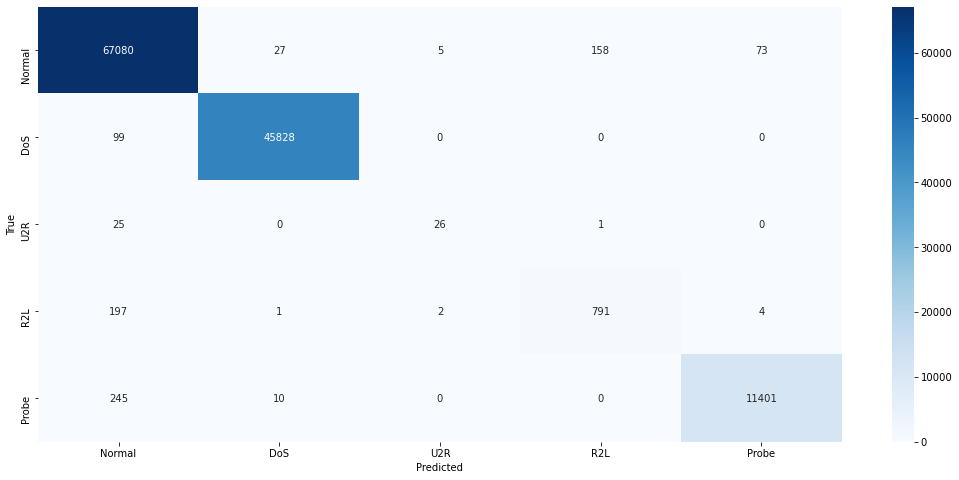

In [40]:
#turn the confusion matrix data into a heat map

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


# set the labels according to 
if class_mode == 1:
    class_labels = ["Normal","Attack"]
if class_mode == 2:
    class_labels = ["Normal","DoS","U2R","R2L","Probe"]
if class_mode == 3:
    class_labels = ["back", "buffer_overflow", "ftp_write", "guess_passwd", "imap", "ipsweep", "land", "loadmodule", 
                    "multihop", "neptune", "nmap", "normal", "perl", "phf", "pod", "portsweep", "rootkit", "satan", 
                    "smurf", "spy", "teardrop", "warezclient", "warezmaster"]
    
                
df_cm = pd.DataFrame(cm, index = [i for i in class_labels],
              columns = [i for i in class_labels])
plt.figure(figsize = (18,8))
sn.heatmap(df_cm, annot=True,cmap="Blues", fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [41]:
import scipy.io
import numpy as np
data = scipy.io.loadmat("nsl_kdd_pytorch.mat")

for i in data:
    if '__' not in i and 'readme' not in i:
            np.savetxt(("nsl_kdd_pytorch.csv"),data[i],delimiter=',')


